Two bridges $B'$ and $B''$ of the cycle $C$ are said to interleave if there are four distinct vertices $a, b, c, d \in V(C)$, appearing in that order on the cycle (but not necessarily adjacent), such that $a$ and $c$ are vertices of attachment of $B'$, and $b$ and $d$ are vertices of attachment of $B''$. Additionally, $B'$ and $B'$ are also said to interleave if they both have exactly three vertices of attachment, these three vertices being the same for $B'$ as for $B'$.

If C has $\ell$ bridges $B_1, \dots, B_{\ell}$, then the interleave graph $H$ has $\ell$ vertices $h_1, \dots, h_{\ell}$, with $h_ih_j \in E(H)$ if and only if $B_i$ and $B_j$ interleave.

Suppose $G$ is a graph with a cycle $C$ that has $\ell$ bridges $B_1, \dots, B_{\ell}$. Then $G$ is planar if and only if the following holds:
*   Each of the subgraphs with edges $E(C) \cup B_i$, $1 \leq i \leq \ell$, is planar.
*   The interleave graph $H$ is bipartite.

We shall give a full proof of this.

Assume we have a planar drawing of $G$. Then clearly, if the entire graph $G$ can be drawn without any edges crossing, then any subgraph can also be drawn without crossings.

By the Jordan curve theorem, the cycle $C$ forms a closed loop that divides the plane into two distinct regions. Every bridge of $C$ must be drawn almost entirely in one of these two regions, except for its attachment points on C. For two bridges that interleave, by definition their attachment points on the cycle alternate. Hence, one must lie on the outside of $C$ and the other on the inside of $C$ to avoid a crossing. This creates two disjoint sets of bridges whereby an edge in the interleave graph $H$ only exists between bridges on different sides of $C$. This is precisely the definition of a bipartite graph.

Now assume that both conditions hold. Since the interleave graph $H$ is bipartite, we can partition all the bridges of $G$ into two sets $A$ and $B$, such that no two bridges within the same set interleave.

First, draw the cycle $C$ homeomorphic to a circle on the plane. Take all the bridges from $A$ and draw them entirely on the inside of the circle. Take all the bridges from $B$ and draw them entirely on the outside of the circle.

By assumption, each individual bridge can be drawn planarly with the cycle. Furthermore, no two bridges drawn on the same side will cross each other, as all bridges inside $A$ (or $B$) do not interleave with each other. Finally, an inside bridge and an outside bridge cannot cross because they are separated by the cycle $C$.

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations

def find_graph_components(graph):
    all_components = []
    visited_nodes = set()
    for node in graph.nodes():
        if node not in visited_nodes:
            current_component = []
            q = deque([node])
            visited_nodes.add(node)
            while q:
                current_node = q.popleft()
                current_component.append(current_node)
                for neighbor in graph.neighbors(current_node):
                    if neighbor not in visited_nodes:
                        visited_nodes.add(neighbor)
                        q.append(neighbor)
            all_components.append(current_component)
    return all_components

def find_bridges_of_cycle(graph, cycle_nodes):
    bridges = []
    cycle_nodes_set = set(cycle_nodes)
    cycle_edges = {tuple(sorted((cycle_nodes[i], cycle_nodes[(i + 1) % len(cycle_nodes)]))) for i in range(len(cycle_nodes))}

    # Find chords
    for u, v in graph.edges():
        if u in cycle_nodes_set and v in cycle_nodes_set and tuple(sorted((u, v))) not in cycle_edges:
            bridges.append({'edges': [(u, v)], 'attachments': sorted([u, v])})

    # Find component-based bridges
    external_nodes = [n for n in graph.nodes() if n not in cycle_nodes_set]
    subgraph = graph.subgraph(external_nodes)
    external_components = find_graph_components(subgraph)

    for component_nodes in external_components:
        component_edges = set(subgraph.subgraph(component_nodes).edges())
        attachments = set()
        for node in component_nodes:
            for neighbor in graph.neighbors(node):
                if neighbor in cycle_nodes_set:
                    component_edges.add(tuple(sorted((node, neighbor))))
                    attachments.add(neighbor)
        if component_edges:
            bridges.append({'edges': list(component_edges), 'attachments': sorted(list(attachments))})
    return bridges

In [27]:
def construct_interleave_graph(cycle_nodes, bridges):
    '''
    Constructs the interleave graph H from a list of bridges.
    Args:
        cycle_nodes: The ordered list of nodes in cycle C.
        bridges: A list of bridges of C.
    Returns:
        The interleave graph H.
    '''
    H = nx.Graph()
    num_bridges = len(bridges)
    H.add_nodes_from(range(num_bridges))

    # A map from cycle node to its position
    node_to_pos = {node: i for i, node in enumerate(cycle_nodes)}

    # Check every pair of bridges for interleaving
    for i, j in combinations(range(num_bridges), 2):
        bridge1 = bridges[i]
        bridge2 = bridges[j]

        attachments1 = set(bridge1['attachments'])
        attachments2 = set(bridge2['attachments'])

        # Condition 1: Three shared attachments
        if len(attachments1) == 3 and attachments1 == attachments2:
            H.add_edge(i, j)
            continue  # Move to the next pair

        # Condition 2: Alternating attachments
        # Get the positions of the attachments on the cycle
        pos1 = sorted([node_to_pos[n] for n in attachments1])
        pos2 = sorted([node_to_pos[n] for n in attachments2])

        interleaves = False
        # Check every pair of attachments from B1 against every pair from B2
        for p1a, p1c in combinations(pos1, 2):
            for p2b, p2d in combinations(pos2, 2):
                # Check for alternating order: a < b < c < d or b < a < d < c
                if (p1a < p2b < p1c < p2d) or (p2b < p1a < p2d < p1c):
                    interleaves = True
                    break
            if interleaves:
                break

        if interleaves:
            H.add_edge(i, j)
    # Relabel to 1-based indexing
    H = nx.relabel_nodes(H, {i: i + 1 for i in range(num_bridges)})
    return H

def is_bipartite(graph):
    '''
    Tests if a graph is bipartite using a BFS-based 2-coloring algorithm.
    Args:
        graph: The graph to test.
    Returns:
        True if the graph is bipartite, False otherwise.
    '''
    colors = {}  # Store colors (1 or -1) of nodes

    for start_node in graph.nodes():
        if start_node not in colors:
            # This node is part of a new, uncolored component
            colors[start_node] = 1
            q = deque([start_node])

            while q:
                u = q.popleft()
                for v in graph.neighbors(u):
                    if v not in colors:
                        # Color the neighbor with the opposite color
                        colors[v] = -1 * colors[u]
                        q.append(v)
                    elif colors[v] == colors[u]:
                        # An edge connects two nodes of the same color,
                        # meaning we found an odd-length cycle.
                        return False # Not bipartite

    return True # All components were successfully 2-colored

Found 3 bridges:
  Bridge 0: attachments [1, 3], edges [(1, 3)]
  Bridge 1: attachments [2, 4], edges [(2, 4)]
  Bridge 2: attachments [1, 2, 3, 4], edges [(4, 5), (2, 5), (3, 5), (1, 5)]

Interleave graph H:
  H has 3 nodes (one for each bridge).
  H has 3 edges: [(1, 2), (1, 3), (2, 3)]

Is the interleave graph H bipartite? False



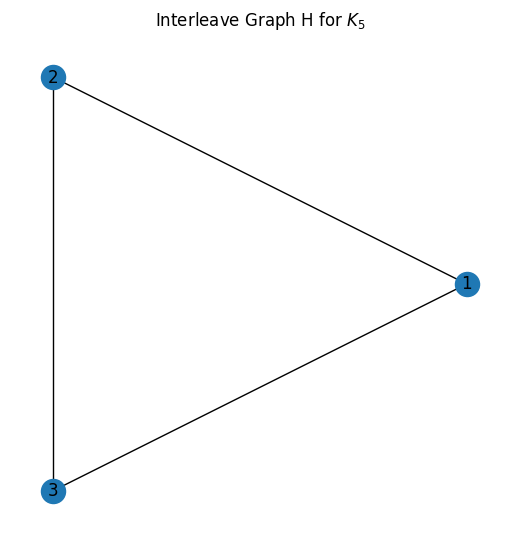

In [29]:
# K5 complete graph
G_k5 = nx.complete_graph(5)
# Relabel nodes to start from 1
G_k5 = nx.relabel_nodes(G_k5, {i: i + 1 for i in range(5)})
cycle_k5 = [1, 2, 3, 4]

# Find the bridges of C in K5
bridges_k5 = find_bridges_of_cycle(G_k5, cycle_k5)
print(f"Found {len(bridges_k5)} bridges:")
for i, bridge in enumerate(bridges_k5):
    print(f"  Bridge {i}: attachments {bridge['attachments']}, edges {bridge['edges']}")

# Construct the interleave graph H
H_k5 = construct_interleave_graph(cycle_k5, bridges_k5)
print("\nInterleave graph H:")
print(f"  H has {H_k5.number_of_nodes()} nodes (one for each bridge).")
print(f"  H has {H_k5.number_of_edges()} edges: {list(H_k5.edges())}")

is_H_bipartite = is_bipartite(H_k5)
print(f"\nIs the interleave graph H bipartite? {is_H_bipartite}\n")

plt.figure(figsize=(5, 5))
nx.draw_circular(H_k5, with_labels=True)
plt.title(f"Interleave Graph H for $K_5$")
plt.show()